## 3- Models

Let's try to train some model to predict needs of clients. Here, we have to predict two target: *AccumulationInvestment* and *IncomeInvestment*. We chose, for each types of algorithms, to implement one model by target. As we have seen, we now have a dataset with 5 feature. This is not a lot so we can train complex model without to much cost and doing overfiting. 

To do so, we have choosen particularly two model : RF and ANN. 

The first one is because it is a ensemble of tree which is maximizing the prediction capacities. And manually, in this problem, we would have done a process of sorting data regarding some value : it's exactly a random forest. Thus, we found this model well fit and hop it will have good perfomance

The second is because of ANN could match up with whatever function we are searching. The need isn't writtable easily thus the objective function must be complicated (non linear for sur) so we expect that ANN will help us with this complexity.
  
To start, we import our previous data.

In [1]:
#Classical Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt

#Importation of the model libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

# Tools'libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from joblib import dump, load

2022-05-18 21:18:47.997509: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-18 21:18:47.997544: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
#Load our datas
%store -r X
%store -r t_inc
%store -r t_acc

In [3]:
#Create the subsets Train (80 %) and Test (20 %)
X_train, X_test, Inc_train, Inc_test, Acc_train, Acc_test = train_test_split(X_inc, t_inc, t_acc, test_size=0.2, shuffle=True, random_state=5)

### Logistic models
  
The first models are the Logistic model. The principe of a Logistic regression is to classify observations into two class: "positive outcome" *C1* and "negative outcom" *C0*. For that, we can compute the conditionned class probability:  
$P(C_1 | \theta) = \frac{1}{1+exp(-w'\theta)}$  
$P(C_0 | \theta) = 1 - P(C_1 | \theta)$  
with $\theta$, the basis functions of the features **x** and **w** the parameters.  
Then, we can decide if the observations $x_i \in C_1$ if $P(C_1 | \theta_i) > Z$ with **Z** a chosen threshold.

First, let apply a feature selection model.

To implement this model, we look for the best hyper-parameters thanks to a K-Cross validation (with 15 folds).

In [ ]:
#Hyper-parameters to optimise
paramGrid = {'penalty': ['none', 'l1', 'l2'], #, #Regularisation
            'C': [0.01, 0.1, 0.7, 1, 5, 10, 15],  #inverse of regularization strength
            'fit_intercept': [False,True] }  #Intercept

#IncomeInvestment model
randomIncLogMod = GridSearchCV(estimator=LogisticRegression(solver='saga', n_jobs=-1, class_weight={0:0.6, 1:0.4}), cv=15,
                                param_grid=paramGrid, n_jobs=-1).fit(X_train, Inc_train)
logIncMod = randomIncLogMod.best_estimator_

#AccumulationInvestment model
randomAccLogMod = GridSearchCV(estimator=LogisticRegression(solver='saga', n_jobs=-1), cv=15,
                                param_grid=paramGrid, n_jobs=-1).fit(X_train, Acc_train)
logAccMod = randomAccLogMod.best_estimator_

#### Best hyper-parameters
Thanks to the computation, we found these results:

In [25]:
#Best hyper-parameters for the IncomeInvestment model
print(logIncMod.get_params())

{'C': 0.1, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': -1, 'penalty': 'l1', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


This model use a Lasso regularization (penalty = l1)

In [26]:
#Best hyper-parameters for the AccumulationInvestment model
print(logAccMod.get_params())

{'C': 0.01, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': -1, 'penalty': 'none', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


This model is without regularization (penalty= None)

### Random Forest
  
Decision trees are a non-parametric supervised learning method. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features (*sklearn.com*).  

Random Forest is an ensemble learning techniques. It uses severales decision trees to make a better prediction by aggregate all of the results of the trees. It is a bagging technique wich allows to reduce the variance of the model.  

For our problem, we will use **Classification trees** wich will give us binary output. The prediction of an input sample is a vote by the trees in the forest, weighted by their probability estimates.

As for the logistic regression, we look for the better hyper-parameters thanks to a K-cross-validation method (with 15 folds).

In [ ]:
#"""
#The code:

#Hyper-parameters to optimise
paramGrid = {'n_estimators': [50, 100, 300], #Number of trees
            'criterion': ['gini', 'entropy'],  #Information gain measure
            'max_depth': [None, 5, 10, 50],  #Maximum depth of the tree
            'max_features': ['sqrt','auto', 'log2'],  #Number of features for the best split
            'bootstrap': [True, False]}  #Bootstrap samples are used

#IncomeInvestment model
rf_randomInc = RandomizedSearchCV(estimator = RandomForestClassifier(n_jobs=-1, class_weight={0:0.6, 1:0.4}), n_iter=432, cv=15, param_distributions = paramGrid, n_jobs = -1)
rf_randomInc.fit(X_train, Inc_train)
rfModInc = rf_randomInc.best_estimator_

#AccumulationInvestment model
rf_randomAcc = RandomizedSearchCV(estimator = RandomForestClassifier(n_jobs=-1), n_iter=432, cv=15, param_distributions = paramGrid, n_jobs = -1)
rf_randomAcc.fit(X_train, Acc_train)
rfModAcc = rf_randomAcc.best_estimator_

#Save the models
dump(rfModInc, 'RandomForestInc.joblib')
dump(rfModAcc, 'RandomForestAcc.joblib')
#"""

**Remarque:** Here, we do not run this code because it has a enorme computational costs (more than 8 minutes for a AMD Ryzen 8 cores). We store it and load it to use it. 

In [8]:
#Load the model
#rfModInc = load('RandomForestInc.joblib')
#rfModAcc = load('RandomForestAcc.joblib')

### Artificial Neural Networks

Artificial Neural Networks (ANNs) are powerful supervised machine learning algorithms. The algorithms learn the relationships between targets and features using a network of functions. Any continuous non-linear relationship can be approximated to arbitrary accuracy using an ANN.  

ANN is composed by multiples layers of neural: 1 *output layer* which is the prediction and *N hidden layer(s)* which are the neurons. In each layers, we have severals neurons that is an **activation function**.  

It is a complex non linear function really powerfull.

In [ ]:
#Parameters
dim, batch = len(X_train[0]), len(X_train)//100
nnIncMod, nnAccMod = Sequential(), Sequential()

#IncomeInvestment model
nnIncMod.add(Dense(units=512, activation='relu', input_dim=dim))
nnIncMod.add(Dense(units=1, activation='sigmoid'))#output layer
nnIncMod.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['Recall', 'AUC', 'accuracy'])
nnIncMod.fit(X_train, Inc_train, batch_size=batch, epochs=60, verbose=1, class_weight={0:0.6, 1:0.4}, use_multiprocessing=True, validation_data=(X_test, Inc_test))

In [ ]:
#Parameters
dim, batch = len(X_train[0]), len(X_train)//100

#AccumulationInvestment model
nnAccMod.add(Dense(units=512, activation='relu', input_dim=dim))
nnAccMod.add(Dense(units=1, activation='sigmoid'))#output layer
nnAccMod.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['Recall', 'AUC', 'accuracy'])
nnAccMod.fit(X_train, Acc_train, batch_size=batch, epochs=100, verbose=1, use_multiprocessing=True, validation_data=(X_test, Acc_test))

### Model valuation

Let us see how the model perform with the test set in order to choose our final model for the two targets. 

In [27]:
# IncomeInvesstisment prediction
predLogInc = logIncMod.predict(X_test)
predRFInc = rfModInc.predict(X_test)
predNnInc = nnIncMod.predict(X_test)

# AccumuulentInvt prediction
predLogAcc = logAccMod.predict(X_test)
predRFAcc = rfModAcc.predict(X_test)
predNnAcc = nnAccMod.predict(X_test)

In [47]:
def metrics(cm, isInc):
    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0] 
    TP = cm[1][1]
    TPR = TP/(TP+FN) ; P = TP/(TP+FP) 
    TNR = (TN/(TN+FP)) ; F1 = (2*P*TPR)/(P+TPR)
    acc = (TP+TN)/(TP+TN+FP+FN)
    if isInc:
        print("Measures for IncomeInvestment:")
    else:
        print("Measures for AccumulationInvestment")
    print(f'Sensitivity = {TPR:2.2%} ;  Specificity = {TNR:2.2%} ; Precision = {P:2.2%} ; F1 score = {F1:2.2%} ; Accuracy = {acc:2.2%}', "\n")

def confusionMat(predInc, predAcc):
    cm1 = confusion_matrix(Inc_test, predInc)
    cm2 = confusion_matrix(Acc_test, predAcc)

    #Plot
    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    group_names = ["True Neg","False Pos","False Neg","True Pos"]
    group_counts1 = ["{0:0.0f}".format(value) for value in cm1.flatten()]
    group_counts2 = ["{0:0.0f}".format(value) for value in cm2.flatten()]
    group_percentages1 = ["{0:.2%}".format(value) for value in cm1.flatten()/np.sum(cm1)]
    group_percentages2 = ["{0:.2%}".format(value) for value in cm2.flatten()/np.sum(cm2)]
    labels1 = np.asarray([f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts1,group_percentages1)]).reshape(2,2)
    labels2 = np.asarray([f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts2,group_percentages2)]).reshape(2,2)
    sns.heatmap(cm1, annot=labels1, fmt="", cmap='Blues', ax=axes[0])
    sns.heatmap(cm2, annot=labels2, fmt="", cmap='Blues', ax=axes[1])
    axes[0].set_title("IncomeInvestment")
    axes[1].set_title("AccumulationInvestment")

    #Metrics
    metrics(cm1, 1)
    metrics(cm2, 0)

Measures for IncomeInvestment:
Sensitivity = 63.04% ;  Specificity = 87.83% ; Precision = 72.97% ; F1 score = 67.64% ; Accuracy = 79.33% 

Measures for AccumulationInvestment
Sensitivity = 70.03% ;  Specificity = 57.58% ; Precision = 63.76% ; F1 score = 66.75% ; Accuracy = 64.00% 



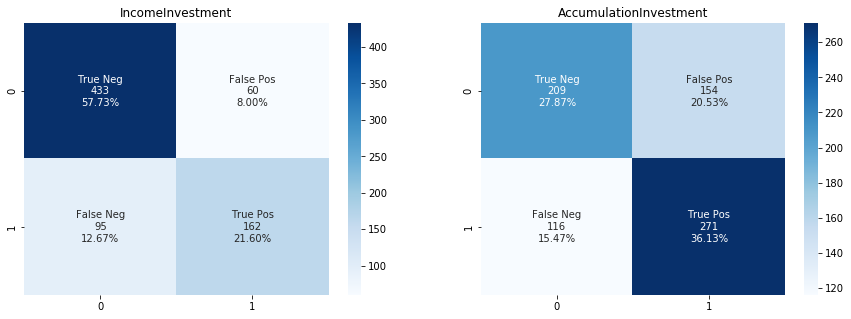

In [48]:
#Valuation of logistic models
confusionMat(predLogInc, predLogAcc)

For the logistic models, the result is not bad especially for the IncomeInvestment model. We can calibrate the parameters for see if we can significatvly improve the models.

Measures for IncomeInvestment:
Sensitivity = 62.65% ;  Specificity = 94.12% ; Precision = 84.74% ; F1 score = 72.04% ; Accuracy = 83.33% 

Measures for AccumulationInvestment
Sensitivity = 73.64% ;  Specificity = 84.57% ; Precision = 83.58% ; F1 score = 78.30% ; Accuracy = 78.93% 



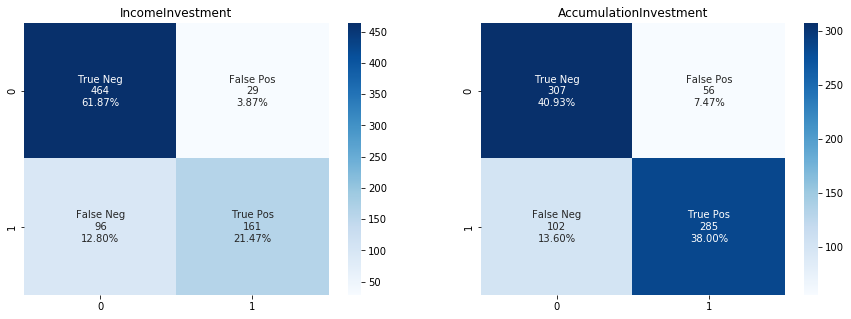

In [49]:
#Valuation of random Forest models
confusionMat(predRFInc, predRFAcc)

The results of the models are very good. The precision and accuracy are very hight. We can try to improve the models via the hyperparameters.

Measures for IncomeInvestment:
Sensitivity = 58.75% ;  Specificity = 93.51% ; Precision = 82.51% ; F1 score = 68.64% ; Accuracy = 81.60% 

Measures for AccumulationInvestment
Sensitivity = 78.29% ;  Specificity = 79.34% ; Precision = 80.16% ; F1 score = 79.22% ; Accuracy = 78.80% 



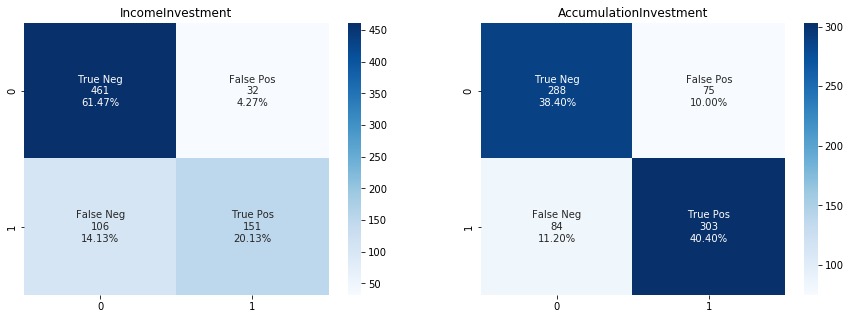

In [50]:
#Valuation of neural Networks models
ipre = (predNnInc > 0.5).astype(int)
apre = (predNnAcc > 0.4).astype(int)

confusionMat(ipre, apre)

Neural Networks model is fine for the IncomeInvestment model but for the AccumulationInvestment, is bad. We didn't exepct that so we can try to improve it. 

## Model Selection and explanations